In [33]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingWarmRestarts

from torchvision import transforms, datasets
from torchvision.datasets import CIFAR10, ImageFolder
import torchvision.transforms.v2 as v2
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

import re


from functools import partial
from typing import List

import torch
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.layers.squeeze_excite import EffectiveSEModule
from timm.models import register_model, build_model_with_cfg, named_apply, generate_default_cfgs
from timm.layers import DropPath
from timm.layers import LayerNorm2d
import timm

In [34]:
if torch.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"Device: {device}")

Device: mps


In [35]:
seed = 29
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [36]:
DATA_ROOT = './data.cifar10'

### Model Specific Transformations

In [37]:
timm_model = timm.create_model('rdnet_tiny.nv_in1k', pretrained=True)
data_config = timm.data.resolve_model_data_config(timm_model)
transform = timm.data.create_transform(**data_config, is_training=True)
test_transform = timm.data.create_transform(**data_config, is_training=False)

In [38]:
print(f"Data Confiuration :{data_config},\nData Transformation: {transform},\nTest Transformation: {test_transform}")

Data Confiuration :{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.9, 'crop_mode': 'center'},
Data Transformation: Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
),
Test Transformation: Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


### Getting the pretrained weights. Hugging face models use .bin format.

In [39]:
torch.save(timm_model.state_dict(), 'rdnet_tiny_pretrained.pth')

### Reproducing the same transformation locally not relying on timm

In [40]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=(224, 224),
        scale=(0.08, 1.0),
        ratio=(0.75, 1.3333),
        interpolation=InterpolationMode.BICUBIC
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=(0.6, 1.4),
        contrast=(0.6, 1.4),
        saturation=(0.6, 1.4)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


test_transform = transforms.Compose([
    transforms.Resize(
        size=248,
        interpolation=InterpolationMode.BICUBIC,
        antialias=True
    ),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

### In case there is a ssl certificate issue

In [41]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


### CIFAR 10 DATA DOWNLOAD

In [42]:
trainset = CIFAR10(root=DATA_ROOT, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=test_transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader

full_dataset = CIFAR10(root=DATA_ROOT, train=True, download=True)
targets = np.array(full_dataset.targets)

sss = StratifiedShuffleSplit(n_splits=1, test_size=5000, random_state=29)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = test_transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

test_dataset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### Defining the Model

In [ ]:
__all__ = ["RDNet"]


class RDNetClassifierHead(nn.Module):
    def __init__(
        self,
        in_features: int,
        num_classes: int,
        drop_rate: float = 0.,
    ):
        super().__init__()
        self.in_features = in_features
        self.num_features = in_features

        self.norm = nn.LayerNorm(in_features)
        self.drop = nn.Dropout(drop_rate)
        self.fc = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def reset(self, num_classes):
        self.fc = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x, pre_logits: bool = False):
        x = x.mean([-2, -1])
        x = self.norm(x)
        x = self.drop(x)
        if pre_logits:
            return x
        x = self.fc(x)
        return x


class PatchifyStem(nn.Module):
    def __init__(self, num_input_channels, num_init_features, patch_size=4):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(num_input_channels, num_init_features, kernel_size=patch_size, stride=patch_size),
            LayerNorm2d(num_init_features),
        )

    def forward(self, x):
        return self.stem(x)


class Block(nn.Module): #this is Feature MIXER
    """D == Dw conv, N == Norm, F == Feed Forward, A == Activation"""
    def __init__(self, in_chs, inter_chs, out_chs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_chs, in_chs, groups=in_chs, kernel_size=7, stride=1, padding=3),
            LayerNorm2d(in_chs, eps=1e-6),
            nn.Conv2d(in_chs, inter_chs, kernel_size=1, stride=1, padding=0),
            nn.GELU(),
            nn.Conv2d(inter_chs, out_chs, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        return self.layers(x)


class BlockESE(nn.Module): # this is Feature MIXER
    """D == Dw conv, N == Norm, F == Feed Forward, A == Activation"""
    def __init__(self, in_chs, inter_chs, out_chs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_chs, in_chs, groups=in_chs, kernel_size=7, stride=1, padding=3),
            LayerNorm2d(in_chs, eps=1e-6),
            nn.Conv2d(in_chs, inter_chs, kernel_size=1, stride=1, padding=0),
            nn.GELU(),
            nn.Conv2d(inter_chs, out_chs, kernel_size=1, stride=1, padding=0),
            EffectiveSEModule(out_chs),
        )

    def forward(self, x):
        return self.layers(x)


class DenseBlock(nn.Module):
    def __init__(
        self,
        num_input_features,
        growth_rate,
        bottleneck_width_ratio, # I think this is wide part of bottleneck
        drop_path_rate,
        drop_rate=0.0,
        rand_gather_step_prob=0.0,
        block_idx=0,
        block_type="Block",
        ls_init_value=1e-6,
        **kwargs,
    ):
        super().__init__()
        self.drop_rate = drop_rate
        self.drop_path_rate = drop_path_rate
        self.rand_gather_step_prob = rand_gather_step_prob
        self.block_idx = block_idx
        self.growth_rate = growth_rate

        self.gamma = nn.Parameter(ls_init_value * torch.ones(growth_rate)) if ls_init_value > 0 else None
        growth_rate = int(growth_rate)
        inter_chs = int(num_input_features * bottleneck_width_ratio / 8) * 8

        if self.drop_path_rate > 0:
            self.drop_path = DropPath(drop_path_rate)

        self.layers = eval(block_type)(
            in_chs=num_input_features,
            inter_chs=inter_chs,
            out_chs=growth_rate, # the concatentation of features
        )

    def forward(self, x):
        if isinstance(x, List):
            x = torch.cat(x, 1)
        x = self.layers(x)

        if self.gamma is not None:
            x = x.mul(self.gamma.reshape(1, -1, 1, 1))

        if self.drop_path_rate > 0 and self.training:
            x = self.drop_path(x)
        return x


class DenseStage(nn.Sequential):
    def __init__(self, num_block, num_input_features, drop_path_rates, growth_rate, **kwargs):
        super().__init__()
        for i in range(num_block):
            layer = DenseBlock(
                num_input_features=num_input_features,
                growth_rate=growth_rate,
                drop_path_rate=drop_path_rates[i],
                block_idx=i,
                **kwargs,
            )
            num_input_features += growth_rate
            self.add_module(f"dense_block{i}", layer)
        self.num_out_features = num_input_features

    def forward(self, init_feature):
        features = [init_feature]
        for module in self:
            new_feature = module(features)
            features.append(new_feature)
        return torch.cat(features, 1)


class RDNet(nn.Module):
    def __init__(
        self,
        num_init_features=64,
        growth_rates=(64, 104, 128, 128, 128, 128, 224),
        num_blocks_list=(3, 3, 3, 3, 3, 3, 3),
        bottleneck_width_ratio=4,
        zero_head=False,
        in_chans=3,  # timm option [--in-chans]
        num_classes=1000,  # timm option [--num-classes]
        drop_rate=0.0,  # timm option [--drop: dropout ratio]
        drop_path_rate=0.0,  # timm option [--drop-path: drop-path ratio]
        checkpoint_path=None,  # timm option [--initial-checkpoint]
        transition_compression_ratio=0.5,
        ls_init_value=1e-6,
        is_downsample_block=(None, True, True, False, False, False, True),
        block_type="Block",
        head_init_scale: float = 1.,
        **kwargs,
    ):
        super().__init__()
        assert len(growth_rates) == len(num_blocks_list) == len(is_downsample_block)

        self.num_classes = num_classes
        if isinstance(block_type, str):
            block_type = [block_type] * len(growth_rates)

        # stem
        self.stem = PatchifyStem(in_chans, num_init_features, patch_size=4)

        # features
        self.feature_info = []
        self.num_stages = len(growth_rates)
        curr_stride = 4  # stem_stride
        num_features = num_init_features
        dp_rates = [x.tolist() for x in torch.linspace(0, drop_path_rate, sum(num_blocks_list)).split(num_blocks_list)]

        dense_stages = []
        for i in range(self.num_stages):
            dense_stage_layers = []
            if i != 0:
                compressed_num_features = int(num_features * transition_compression_ratio / 8) * 8
                k_size = stride = 1
                if is_downsample_block[i]:
                    curr_stride *= 2
                    k_size = stride = 2
                dense_stage_layers.append(LayerNorm2d(num_features))
                dense_stage_layers.append(
                    nn.Conv2d(num_features, compressed_num_features, kernel_size=k_size, stride=stride, padding=0)
                )
                num_features = compressed_num_features

            stage = DenseStage(
                num_block=num_blocks_list[i],
                num_input_features=num_features,
                growth_rate=growth_rates[i],
                bottleneck_width_ratio=bottleneck_width_ratio,
                drop_rate=drop_rate,
                drop_path_rates=dp_rates[i],
                ls_init_value=ls_init_value,
                block_type=block_type[i],
            )
            dense_stage_layers.append(stage)
            num_features += num_blocks_list[i] * growth_rates[i]

            if i + 1 == self.num_stages or (i + 1 != self.num_stages and is_downsample_block[i + 1]):
                self.feature_info += [
                    dict(
                        num_chs=num_features,
                        reduction=curr_stride,
                        module=f'dense_stages.{i}',
                        growth_rate=growth_rates[i],
                    )
                ]
            dense_stages.append(nn.Sequential(*dense_stage_layers))
        self.dense_stages = nn.Sequential(*dense_stages)

        # classifier
        self.head = RDNetClassifierHead(num_features, num_classes, drop_rate=drop_rate)

        # initialize weights
        named_apply(partial(_init_weights, head_init_scale=head_init_scale), self)

        if zero_head:
            nn.init.zeros_(self.head[-1].weight.data)
            if self.head[-1].bias is not None:
                nn.init.zeros_(self.head[-1].bias.data)

        if checkpoint_path is not None:
            self.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))

    @torch.jit.ignore
    def get_classifier(self):
        return self.head.fc

    def reset_classifier(self, num_classes=0, global_pool=None):
        assert global_pool is None
        self.head.reset(num_classes)

    def forward_head(self, x, pre_logits: bool = False):
        return self.head(x, pre_logits=True) if pre_logits else self.head(x)

    def forward_features(self, x):
        x = self.stem(x)
        x = self.dense_stages(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def group_matcher(self, coarse=False):
        assert not coarse
        return dict(
            stem=r'^stem',
            blocks=r'^dense_stages\.(\d+)',
        )


def _init_weights(module, name=None, head_init_scale=1.0):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Linear):
        nn.init.constant_(module.bias, 0)
        if name and 'head.' in name:
            module.weight.data.mul_(head_init_scale)
            module.bias.data.mul_(head_init_scale)

### Defining TINY_RDNET Configuration

In [45]:
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

rdnet_tiny_cfg = {
    "url": "",  # optional: local path to weights if needed
    "num_classes": 1000,
    "input_size": (3, 224, 224),
    "crop_pct": 0.9,
    "interpolation": "bicubic",
    "mean": IMAGENET_DEFAULT_MEAN,
    "std": IMAGENET_DEFAULT_STD,
    "first_conv": "stem.0",
    "classifier": "head.fc",
}


### RDNet Constructor

In [46]:
def rdnet_tiny(pretrained=False, num_classes=1000, checkpoint_path=None, device="cpu", **kwargs):
    n_layer = 7
    model_args = {
        "num_init_features": 64,
        "growth_rates": [64, 104, 128, 128, 128, 128, 224],
        "num_blocks_list": [3] * n_layer,
        "is_downsample_block": (None, True, True, False, False, False, True),
        "transition_compression_ratio": 0.5,
        "block_type": ["Block", "Block", "BlockESE", "BlockESE", "BlockESE", "BlockESE", "BlockESE"],
        "num_classes": num_classes,
    }

    model = RDNet(**{**model_args, **kwargs})

    if pretrained:
        assert checkpoint_path is not None, "Please provide checkpoint_path for pretrained weights"
        state_dict = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(state_dict, strict=False)

    return model

### First Loading the model weights

In [47]:
model = rdnet_tiny(pretrained=True, checkpoint_path="rdnet_tiny_pretrained.pth", device = device)

### Now resetting the classifier head

In [48]:
model.reset_classifier(num_classes=10)
model.to(device)

RDNet(
  (stem): PatchifyStem(
    (stem): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
    )
  )
  (dense_stages): Sequential(
    (0): Sequential(
      (0): DenseStage(
        (dense_block0): DenseBlock(
          (layers): Block(
            (layers): Sequential(
              (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
              (1): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
              (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
              (3): GELU(approximate='none')
              (4): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
            )
          )
        )
        (dense_block1): DenseBlock(
          (layers): Block(
            (layers): Sequential(
              (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
              (1): LayerNorm2d((128,), eps=1e-06, el

### Defining a handy evaluate function

In [49]:
def evaluate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    loss_fn = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            # with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [50]:
import math

In [51]:
def train_rdnet_tiny(model, train_loader, val_loader, test_loader, device, num_epochs=20, 
                    initial_lr=1e-3, weight_decay=0.05, betas=(0.9, 0.999), 
                    save_interval=10, resume_path=None, model_name_prefix='rdnet_tiny_transfer_learn',
                    early_stopping_patience=10, run_name="model", sub_dir_seed_number='seed_29'):
    model.to(device)
    warmup_epochs = int(math.ceil((10/100)*num_epochs))
    # Optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=initial_lr, betas=betas, weight_decay=weight_decay)
    warmup_scheduler = LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
    cosine_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=1, eta_min=1e-6)  #TODO: Change T_0 = 6 so first cosine cycle is 6 epochs instead of 2.
    scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])
    
    # Loss function
    criterion = nn.CrossEntropyLoss()


    best_val_loss = float('inf')
    correspondin_val_acc = 0.0
    start_epoch = 0
    early_stopping_counter = 0

    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    # Resume from checkpoint
    if resume_path and os.path.exists(resume_path):
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        history = checkpoint['history']
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = history['val_loss'][-1]
        correspondin_val_acc = history['val_acc'][-1]
        print(f"Resuming training from epoch {start_epoch}")

    try:
        for epoch in range(start_epoch, num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            train_loss = running_loss / total
            train_acc = 100. * correct / total

            
            val_loss, val_acc = evaluate(model, val_loader, device)


            test_loss, test_acc = evaluate(model, test_loader, device)

            history['epoch'].append(epoch)
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)

            print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Test Loss: {test_loss:.4f} | "
                  f"Test Acc: {test_acc:.2f}%")

     
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                correspondin_val_acc = val_acc
                early_stopping_counter = 0
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'history': history
                }
                os.makedirs(f'{run_name}/{sub_dir_seed_number}', exist_ok=True)
                save_path = os.path.join(f'{run_name}/{sub_dir_seed_number}', f"{model_name_prefix}__valLoss{val_loss:.4f}_valAcc{correspondin_val_acc:.2f}.pth")
                torch.save(checkpoint, save_path)
                print(f"Saved best checkpoint at {save_path}")
            else:
                early_stopping_counter += 1
                print(f"No improvement in validation loss for {early_stopping_counter} epoch(s).")

            scheduler.step()
            
            # Save periodic checkpoints
            if epoch % save_interval == 0:
                os.makedirs(f'{run_name}/{sub_dir_seed_number}/periodic', exist_ok=True)
                save_path = os.path.join(f'{run_name}/{sub_dir_seed_number}/periodic', f"{model_name_prefix}_epoch{epoch}.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'history': history
                }, save_path)
                print(f"Saved periodic checkpoint at {save_path}")

            # Early stopping
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                os.makedirs(f'{run_name}/{sub_dir_seed_number}/earlystopping', exist_ok=True)
                save_path = os.path.join(f'{run_name}/{sub_dir_seed_number}/earlystopping', f"{model_name_prefix}_epoch{epoch}.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'history': history
                }, save_path)
                print(f"Saved periodic checkpoint at {save_path}")
                break

        os.makedirs(f'{run_name}/{sub_dir_seed_number}/last_epoch', exist_ok=True)
        save_path = os.path.join(f'{run_name}/{sub_dir_seed_number}/last_epoch', f"{model_name_prefix}_epoch{epoch}.pth")
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history
        }, save_path)
        return history, correspondin_val_acc

    except KeyboardInterrupt:
        print("Training interrupted! Saving checkpoint...")
        os.makedirs(f'{run_name}/{sub_dir_seed_number}/KeyboardInterrupt', exist_ok=True)
        save_path = os.path.join(f'{run_name}/{sub_dir_seed_number}/KeyboardInterrupt', f"{model_name_prefix}_interrupted_epoch{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, save_path)
        print(f"Checkpoint saved at {save_path}. You can resume training from here.")
        return history, correspondin_val_acc

In [52]:
# train_rdnet_tiny(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     test_loader=test_loader,
#     device=device,
#     num_epochs=20,
#     initial_lr=1e-3,
#     weight_decay=0.05,
#     betas=(0.9, 0.999),
#     save_interval=10,
#     resume_path=None,
#     model_name_prefix='rdnet_tiny_transfer_learn',
#     early_stopping_patience=10,
#     run_name="model",
#     sub_dir_seed_number='seed_29'
# )

### Now since we have the model weights for CIFAR 10 we can directly load them into the RDNet Tiny.

In [53]:
path_to_cifar10_weights = "rdnet_tiny_transfer_learn__valLoss0.1992_valAcc93.86.pth"
# Make sure num_classes is correct here
model = rdnet_tiny(pretrained=False, num_classes=10)
checkpoint = torch.load(path_to_cifar10_weights, map_location=device, weights_only=False)

### Checkpoint configuration is as follows

In [54]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'history'])

### Accessing the model state dict

In [55]:
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

RDNet(
  (stem): PatchifyStem(
    (stem): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
    )
  )
  (dense_stages): Sequential(
    (0): Sequential(
      (0): DenseStage(
        (dense_block0): DenseBlock(
          (layers): Block(
            (layers): Sequential(
              (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
              (1): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
              (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
              (3): GELU(approximate='none')
              (4): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
            )
          )
        )
        (dense_block1): DenseBlock(
          (layers): Block(
            (layers): Sequential(
              (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
              (1): LayerNorm2d((128,), eps=1e-06, el

In [56]:
model.eval()
model.to(device)
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)
outputs = model(inputs)
_, preds = outputs.max(1)

print("Predictions:", preds[:10])
print("Targets:    ", targets[:10])

Predictions: tensor([1, 1, 5, 7, 9, 8, 2, 2, 5, 4], device='mps:0')
Targets:     tensor([1, 1, 5, 7, 9, 8, 2, 3, 5, 4], device='mps:0')


==================================================	Stats for val loader	==================================================
F1 Score (Macro):    0.9386
F1 Score (Micro):    0.9386
F1 Score (Weighted): 0.9386

Classification Report:
              precision    recall  f1-score   support

    airplane       0.94      0.96      0.95       500
  automobile       0.98      0.96      0.97       500
        bird       0.91      0.95      0.93       500
         cat       0.91      0.87      0.89       500
        deer       0.94      0.95      0.94       500
         dog       0.90      0.91      0.90       500
        frog       0.98      0.93      0.96       500
       horse       0.94      0.97      0.95       500
        ship       0.92      0.97      0.95       500
       truck       0.97      0.93      0.95       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



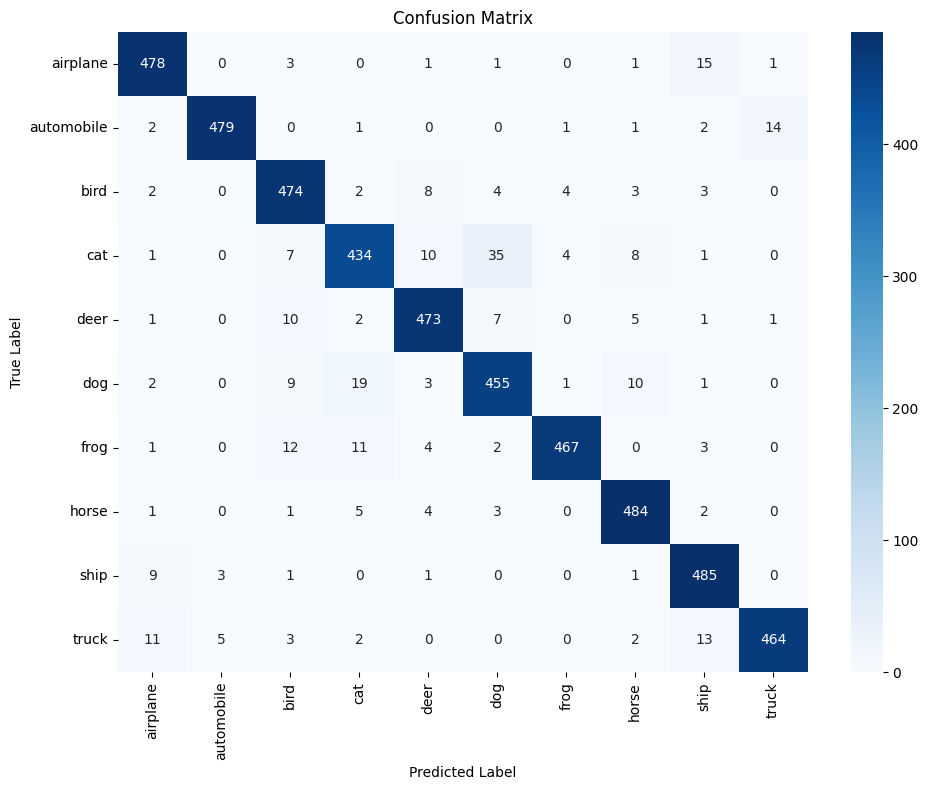

==================================================	Stats for test loader	==================================================
F1 Score (Macro):    0.9322
F1 Score (Micro):    0.9324
F1 Score (Weighted): 0.9322

Classification Report:
              precision    recall  f1-score   support

    airplane       0.92      0.96      0.94      1000
  automobile       0.96      0.96      0.96      1000
        bird       0.90      0.92      0.91      1000
         cat       0.90      0.84      0.87      1000
        deer       0.93      0.94      0.94      1000
         dog       0.91      0.90      0.90      1000
        frog       0.97      0.95      0.96      1000
       horse       0.94      0.97      0.96      1000
        ship       0.94      0.96      0.95      1000
       truck       0.96      0.92      0.94      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



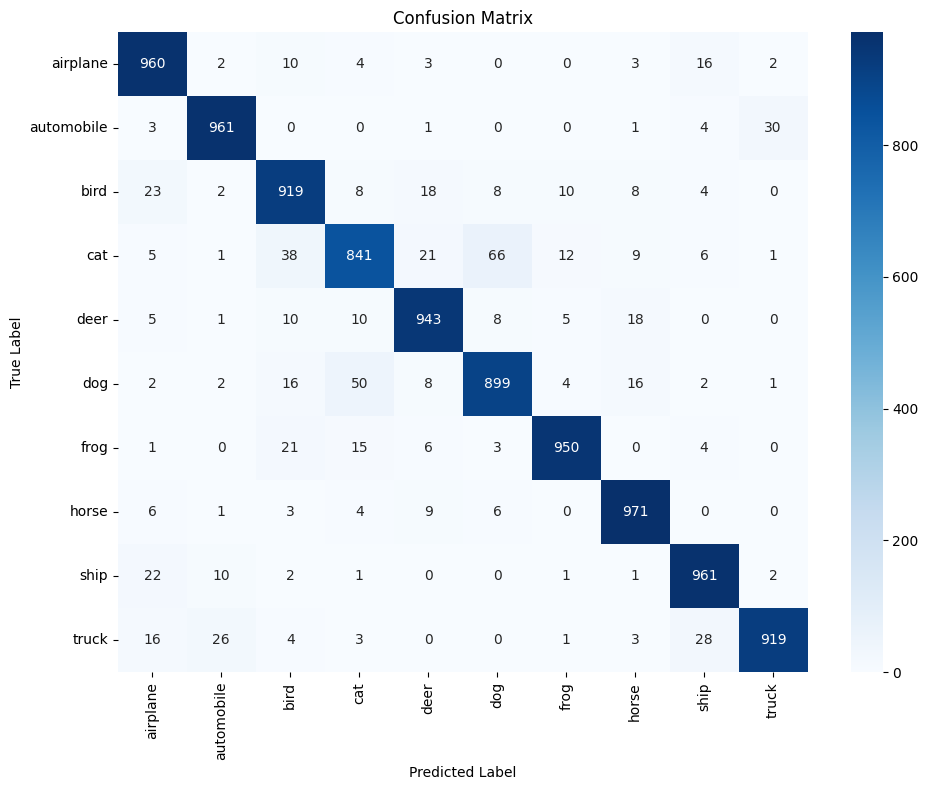

==================================================	Stats for train loader	==================================================
F1 Score (Macro):    0.9852
F1 Score (Micro):    0.9852
F1 Score (Weighted): 0.9852

Classification Report:
              precision    recall  f1-score   support

    airplane       0.97      0.99      0.98      4500
  automobile       0.99      0.99      0.99      4500
        bird       0.99      0.99      0.99      4500
         cat       0.98      0.97      0.98      4500
        deer       0.99      0.99      0.99      4500
         dog       0.98      0.98      0.98      4500
        frog       1.00      0.99      0.99      4500
       horse       0.98      1.00      0.99      4500
        ship       0.98      0.99      0.99      4500
       truck       0.99      0.97      0.98      4500

    accuracy                           0.99     45000
   macro avg       0.99      0.99      0.99     45000
weighted avg       0.99      0.99      0.99     45000



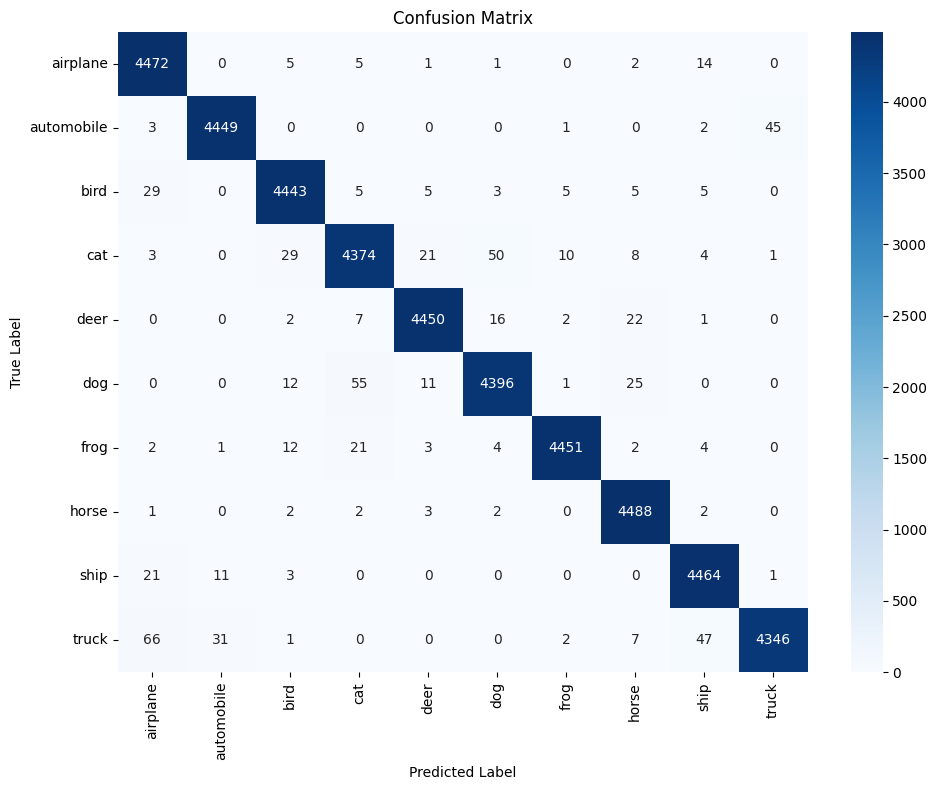

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    print(f"F1 Score (Macro):    {f1_macro:.4f}")
    print(f"F1 Score (Micro):    {f1_micro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = class_names if class_names else "auto", yticklabels = class_names if class_names else "auto")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()
    
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

print(50*"="+"\tStats for val loader\t"+"="*50)
evaluate_model(model, val_loader, device, class_names)
print(50*"="+"\tStats for test loader\t"+"="*50)
evaluate_model(model, test_loader, device, class_names)
print(50*"="+"\tStats for train loader\t"+"="*50)
evaluate_model(model, train_loader, device, class_names)
